$\textbf{PNR vs Bucket comparison for HiRANQS}$

In [1]:
from qutip import *
from numpy import *
from pylab import *
import numpy
from scipy.special import*  
import scipy.optimize as opt
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from tqdm import tqdm
import time
from tqdm import *

/opt/anaconda3/lib/python3.7/site-packages/qutip/__init__.py:93: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.13.
  .format(_cy_require, _Cython.__version__)


$\textbf{Bucket detectors based on}$

$\textit{BucketDetector_realistic_detector }\text{model : Kok, P. and Lovett, B.W.,"Introduction to Optical
Quantum Information Processing," Cambridge University Press, 2010 }$
$\textit{Bucket_Detector}\text{ model: Lee et al, "Towards photonstatistics from photon-number discriminating detectors," Journal of Modern Optics,}$ $\textbf{51}$ $\text{, 1517-1528 (2004)}$

In [2]:
def choose(n, k):
    if 0 <= k <= n:
        ntok = 1
        ktok = 1
        for t in range(1, min(k, n - k) + 1):
            ntok *= n
            ktok *= t
            n -= 1
        return ntok // ktok
    else:
        return 0
def factorial(n):
    if n < 2:
        return 1
    else:
        return n * factorial(n-1)


def BucketDetector_realistic_detector(N,efficiency,n_factor):
    
    proj=zeros((N,N))
    #APD (Bucket Detector) un_detector (=gives probability for 0-detection)
    un_proj=identity(N)
    #n_factor = 0;
    for i in range(N):
        probs = 0;
        for k in range (1,100):
            for d in range(k+1):
                if k-d<=i:
                    probs= probs+ (exp(-n_factor)*(n_factor)**(d))/factorial(d)*choose(i,k-d)*efficiency**(k-d)*(1-efficiency)**(i-k+d)
            
        proj[i,i]=probs
       

    un_proj = un_proj-proj
    un_proj = Qobj(un_proj)
    proj = Qobj(proj)
    return [proj,un_proj]

# $\textbf{Squashing model}$ 


In [3]:
def measure_2folds_4modes_squashing_optimized(dim,Var0,proj,proj2,tau):
    Param=[loss_a,loss_b,n_factor_a,n_factor_b,dim];
    #Param=[loss_a,loss_b,n_factor,n_factor,N]
    vacc = basis(Param[4],0)
    #ida=qeye(N)
    #final_state=psi_i
    det_exp = zeros((2,2,2,2))
    H_sq = 1j*Var0[0]*(tensor(create(Param[4]),create(Param[4]))+tensor(destroy(Param[4]),destroy(Param[4])))
    #print(N)
    #exponentiate hamiltonian and apply it to vaccuum state to make an SPDC state 
    U_sq = H_sq.expm()
    spdc =U_sq*tensor(vacc,vacc)
    psi_i = tensor(spdc,spdc)
    out_i = reshape(transpose(reshape(psi_i.full(), (Param[4],Param[4],Param[4],-1)),(0,3,2,1)),(Param[4]*Param[4]*Param[4]*Param[4],-1))
    psi_i = Qobj(out_i,dims = [[Param[4], Param[4], Param[4], Param[4]], [1, 1, 1, 1]])
    #i,j,k,l means Ha,Va,Hb,Vb, 0 means detector clicked, 1 means detector did not click
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    #expectation values for different detector configurations
                    det_exp[i][j][k][l] = abs(expect(tensor(proj[i],proj[j],proj2[k],proj2[l]),psi_i))
    #two fold probabilities
    HH = (det_exp[0][1][0][1]+0.5*(det_exp[0][0][0][1]+det_exp[0][1][0][0])+0.25*det_exp[0][0][0][0])/(1+ tau*(det_exp[0][1][0][1]+0.5*(det_exp[0][0][0][1]+det_exp[0][1][0][0])+0.25*det_exp[0][0][0][0]))
    VV = (det_exp[1][0][1][0]+0.5*(det_exp[0][0][1][0]+det_exp[1][0][0][0])+0.25*det_exp[0][0][0][0])/(1+tau*(det_exp[1][0][1][0]+0.5*(det_exp[0][0][1][0]+det_exp[1][0][0][0])+0.25*det_exp[0][0][0][0]))
    HV = (det_exp[0][1][1][0]+0.5*(det_exp[0][0][1][0]+det_exp[0][1][0][0])+0.25*det_exp[0][0][0][0])/(1+tau*(det_exp[0][1][1][0]+0.5*(det_exp[0][0][1][0]+det_exp[0][1][0][0])+0.25*det_exp[0][0][0][0]))
    VH = (det_exp[1][0][0][1]+0.5*(det_exp[0][0][0][1]+det_exp[1][0][0][0])+0.25*det_exp[0][0][0][0])/(1+ tau*(det_exp[1][0][0][1]+0.5*(det_exp[0][0][0][1]+det_exp[1][0][0][0])+0.25*det_exp[0][0][0][0]))

    return [HH,HV,VH,VV]


# $\textbf{Key Rate Calculation}$ 


In [4]:
def sim_qkd_entanglement_01(chi,Param):

    vacc = basis(Param[4],0)

    
    qber_list=[]
    twofolds_list=[]
    D=1
    for i in range(D):

        a_det = BucketDetector_realistic_detector(Param[4],loss_a,n_factor_a)
        b_det = BucketDetector_realistic_detector(Param[4],loss_b,n_factor_b)

        probs2f_i= measure_2folds_4modes_squashing_optimized(Param[4],chi,a_det,b_det,tau)

        twofolds_i=probs2f_i[0]+probs2f_i[1]+probs2f_i[2]+probs2f_i[3]
        twofolds_list.append(twofolds_i)

        qber_i=(probs2f_i[0]+probs2f_i[3])
        qber_list.append(qber_i)
    twofolds=sum(twofolds_list)
    qber=sum(qber_list)/sum(twofolds_list)
 
    if qber>0:
        H2=-qber*log2(qber) - (1-qber)*log2(1-qber)
    else:
        H2 = 0

    f_e = 1.16904371810274 + qber

    skr=-1.0*real(twofolds*0.5*(1-(1+f_e)*H2))
    return [skr]

# $\textbf{Quantum Bit Error Rate Calculation}$ 

In [5]:
def sim_qkd_entanglement_02(chi,Param):
    #make vaccuum state
    #Param=[loss_a,loss_b,n_factor,n_factor,N]
    vacc = basis(Param[4],0)
    #make squeezing operator for SPDC
    
    qber_list=[]
    twofolds_list=[]
    D=1
    for i in range(D):

        a_det = BucketDetector_realistic_detector(Param[4],loss_a,n_factor_a)
        b_det = BucketDetector_realistic_detector(Param[4],loss_b,n_factor_b)
    
    #measure detection probabilities
        probs2f_i=measure_2folds_4modes_squashing_optimized(Param[4],chi,a_det,b_det,tau)

    #Rates returned are 'per pulse', so multiply by source rate
        twofolds_i=probs2f_i[0]+probs2f_i[1]+probs2f_i[2]+probs2f_i[3]
        twofolds_list.append(twofolds_i)
    #Determine QBER from returned detection probabilities
        qber_i=(probs2f_i[0]+probs2f_i[3])
        qber_list.append(qber_i)
    twofolds=sum(twofolds_list)
    qber=sum(qber_list)/sum(twofolds_list)
    #calculate the entropy of the qber  
    if qber>0:
        H2=-qber*log2(qber) - (1-qber)*log2(1-qber)
    else:
        H2 = 0
    # estimate error correction efficiency from the CASCADE algorithm 
    f_e = 1.16904371810274 + qber
    #security analysis - calculate skr in infinite key limit
    #See Chris Erven's PhD thesis or Xiongfeng Ma's paper 
    #to understand where this equation comes from
    skr=-1.0*real(twofolds*0.5*(1-(1+f_e)*H2))
    return [qber,twofolds]

# simulation parameters

In [6]:

if __name__=='__main__':

#define the fock space
    dim = 3
#define the squeezing paramter
    sqp = 0.2
    Var0=sqp
#define the noise factor
    n_factor_a = 1e-7
    n_factor_b = 1e-6
    skr = zeros(60)
    qber= zeros(60)
    twofolds=zeros(60)
    optparam11=zeros(60)
#define the length of the coincidence window (in s)
    coinc_window = 1e-9
#define deadtime as a factor of the coincidence window
    tau=1000
    loss_db = arange(0,65)
def Constraint3(Var0):
    return Var0

Quick verification

In [7]:
#%%timeit
results1=[]
for i in range(5):
        loss_a =10.0**(-loss_db[i]/10.0);
        loss_b =10.0**(-loss_db[i]/10.0);
        Param=[loss_a,loss_b,n_factor_a,n_factor_b,dim];
        bnds = [(0.0,1)]
        chi=[sqp];
        myoptions = {'rhobeg': 0.01,'disp':True,'maxiter' : 10000, 'catol':0.00000000000001};
        conts3 = {'type':'ineq','fun':Constraint3}
        results1.append(opt.minimize(sim_qkd_entanglement_01, chi, method = 'COBYLA', args = Param, constraints = conts3, options = myoptions))
        [skr[i]] = sim_qkd_entanglement_01(results1[i].x,Param)
        [qber[i],twofolds[i]]=sim_qkd_entanglement_02(results1[i].x,Param)
        [optparam11[i]] = results1[i].x;
skr13 = -skr/coinc_window
qber11 = qber*100

Optimization/key rate calculation for the different scenarios

In [8]:
import multiprocessing
def Par_funct(x):
    def sim_qkd_entanglement_001(chi,Param):
        Param=[loss_a,loss_b,n_factor_a,n_factor_b,dim]
        vacc = basis(Param[4],0)
        qber_list=[]
        twofolds_list=[]
        N=1
        for i in range(N):
            a_det = BucketDetector_realistic_detector(Param[4],loss_a,n_factor_a)
            b_det = BucketDetector_realistic_detector(Param[4],loss_b,n_factor_b)

            probs2f_i=measure_2folds_4modes_squashing_optimized(Param[4],chi,a_det,b_det,tau)
            twofolds_i=probs2f_i[0]+probs2f_i[1]+probs2f_i[2]+probs2f_i[3]
            twofolds_list.append(twofolds_i)
            qber_i=(probs2f_i[0]+probs2f_i[3])
            qber_list.append(qber_i)
        twofolds=sum(twofolds_list)
        qber=sum(qber_list)/sum(twofolds_list)
        if qber>0:
            H2=-qber*log2(qber) - (1-qber)*log2(1-qber)
        else:
            H2 = 0
        f_e = 1.16904371810274 + qber
        skr=-1.0*real(twofolds*0.5*(1-(1+f_e)*H2))
        return [skr]
    def sim_qkd_entanglement_002(chi,Param):
        vacc = basis(Param[4],0) 
        qber_list=[]
        twofolds_list=[]
        N=1
        for i in range(N):
            a_det = BucketDetector_realistic_detector(Param[4],loss_a,n_factor_a)
            b_det = BucketDetector_realistic_detector(Param[4],loss_b,n_factor_b)
            probs2f_i=measure_2folds_4modes_squashing_optimized(Param[4],chi,a_det,b_det,tau)
            twofolds_i=probs2f_i[0]+probs2f_i[1]+probs2f_i[2]+probs2f_i[3]
            twofolds_list.append(twofolds_i)
            qber_i=(probs2f_i[0]+probs2f_i[3])
            qber_list.append(qber_i)
        twofolds=sum(twofolds_list)
        qber=sum(qber_list)/sum(twofolds_list)
        if qber>0:
            H2=-qber*log2(qber) - (1-qber)*log2(1-qber)
        else:
            H2 = 0
        f_e = 1.16904371810274 + qber
        skr=-1.0*real(twofolds*0.5*(1-(1+f_e)*H2))
        return [qber,twofolds]
    loss_a =10.0**(-x/10.0);
    loss_b =(10.0**(-40/10.0));
    Param=[loss_a,loss_b,n_factor_a,n_factor_b,dim,tau];
    bnds = [(0.0,1)]
    chi=[sqp];
    myoptions = {'disp':True,'maxiter' : 10000, 'ftol':0.000000000000000000000000001};
    conts3 = {'type':'ineq','fun':Constraint3}
    results=opt.minimize(sim_qkd_entanglement_001, chi, method = 'SLSQP', args = Param, bounds=bnds, constraints = conts3, options = myoptions)
    [skr] = sim_qkd_entanglement_001(results.x,Param)
    [qber,twofolds]=sim_qkd_entanglement_002(results.x,Param)
    [optparam12] = results.x;
    skr12 = -skr/coinc_window
    qber12 = qber*100
    return[skr12,qber12,optparam12]

pool_obj = multiprocessing.Pool()



Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.7408855962883078e-06
            Iterations: 13
            Function evaluations: 39
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.3841251517384086e-06
            Iterations: 14
            Function evaluations: 42
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -5.740340829804945e-07
            Iterations: 13
            Function evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Gradient evaluations: 13
            Current function value: -7.455222687225206e-07
            Iterations: 13
            Function evaluations: 47
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9.768042506629757e-07
            Iterations: 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


            Function evaluations: 66


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1315977293807995e-28
            Iterations: 21
            Function evaluations: 65
Optimization terminated successfully.    (Exit mode 0)
            Gradient evaluations: 21
            Current function value: -1.3845143679344883e-17
            Iterations: 29
            Function evaluations: 88
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.48583278283766e-27
            Iterations: 44
            Function evaluations: 158
            Gradient evaluations: 44
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.941687850238383e-27
            Iterations: 76
            Function evaluations: 284
            Gradient evaluations: 76
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.9599676518

In [9]:
answer1 = list(tqdm(pool_obj.imap(Par_funct,range(0,len(loss_db))),total=len(loss_db),desc="Progress"))
print(answer1)

Progress: 100%|██████████| 65/65 [00:18<00:00,  3.54it/s]

[[3332.2115233134687, 4.979099487058085, 0.2964375556790886], [2384.1251517384085, 5.145034457948348, 0.28162778746016726], [1740.8855962883076, 5.233927512293558, 0.26958332611973335], [1294.5198037860366, 5.285106397852351, 0.26027235179345276], [976.8042506629756, 5.316608399743885, 0.2531658176424006], [745.5222687225205, 5.337093317974852, 0.24773917630474715], [574.0340829804945, 5.35100487483289, 0.24357585910056753], [445.0058938560888, 5.3607782843331595, 0.2403639621413977], [346.79905236762465, 5.3678289497690965, 0.23787304800013506], [271.37169610776505, 5.373021801552526, 0.2359324466380703], [213.02713506141245, 5.376910184571164, 0.23441481457686975], [167.6440816934827, 5.3798582223370435, 0.23322426186155854], [132.18749578664162, 5.38212109226131, 0.23228784510656433], [104.39031307675685, 5.383872836672679, 0.2315497821817052], [82.53836173714465, 5.38524061851469, 0.2309670438915334], [65.32299318408941, 5.386317830040836, 0.23050625616314005], [51.7372668791238, 5

In [10]:
l1 = [float(item[0]) for item in answer1]
l2=[float(item[1]) for item in answer1]
l3=[float(item[2]) for item in answer1]

# Plot SKR and QBER

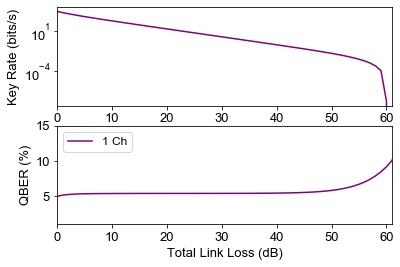

In [11]:
    #plot results
fig = plt.figure()
ax1 = fig.add_subplot(211)
#ax1.plot(loss_db, l951,'-',color="blue", label="95 Ch")
#ax1.plot(loss_db, l401,'-',color="green",label="40 Ch" )
#ax1.plot(loss_db, l41,'-',color="grey",label="4 Ch" )
ax1.plot(loss_db, l1,'-',color="purple",label="1 Ch" )
ax1.set_yscale('log')
ax1.set_ylabel('Key Rate (bits/s)',fontsize=13)
#ax1.set_xlabel('Loss (dB)')
ax2 = fig.add_subplot(212)
#ax2.plot(loss_db, l952,'-',color="blue",label="95 Ch" )
#ax2.plot(loss_db, l402,'-',color="green",label="40 Ch" )
#ax2.plot(loss_db, l42,'-',color="grey",label="4 Ch" )
ax2.plot(loss_db, l2,'-',color="purple",label="1 Ch" )
ax2.legend(loc="upper left",fontsize=12)
ax2.set_ylabel('QBER (%)',fontsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)
ax2.set_xlim([0,61])
ax1.set_xlim([0,61])
ax2.set_ylim([1,15])
ax2.set_xlabel('Total Link Loss (dB)',fontsize=13)
plt.style.use('seaborn-white')
#plt.savefig('40dB3.eps', format='eps')

Plot squeezing parameter